In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns 

In [2]:
df = pd.read_csv("AirPassengers.csv")

In [3]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.index = df['Month']
del df['Month']
df.rename(columns={"#Passengers": "Passengers"}, inplace=True)

In [4]:
df['Trend'] = range(1,len(df)+1)
df['MonthNum'] = df.index.month
df['LogPassengers'] = np.log(df.Passengers)

Getting out-of sample predictions from the Statsmodels formula API

In [5]:
df_ft = df[0:-12]

In [6]:
model = sm.ols(formula="LogPassengers ~ Trend + C(MonthNum)", data=df_ft)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          LogPassengers   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     564.3
Date:                Tue, 31 May 2022   Prob (F-statistic):           9.62e-99
Time:                        14:09:26   Log-Likelihood:                 196.78
No. Observations:                 132   AIC:                            -367.6
Df Residuals:                     119   BIC:                            -330.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7152      0.019    247.172      0.000       4.677       4.753
C(MonthNum)[T.2]     -0.0175      0.024     -0.716      0.475      -0.066       0.031
C(MonthNum)[T.3]      0.1189      0.024      4.859      0.000       0.070       0.167
C(MonthNum)[T.4]      0.0768      0.024      3.138      0.002       0.028       0.125
C(MonthNum)[T.5]      0.0728      0.024      2.972      0.004       0.024       0.121
C(MonthNum)[T.6]      0.1953      0.024      7.977      0.000       0.147       0.244
C(MonthNum)[T.7]      0.2957      0.024     12.075      0.000       0.247       0.344
C(MonthNum)[T.8]      0.2886      0.024     11.783      0.000       0.240       0.337
C(MonthNum)[T.9]      0.1475      0.024      6.021      0.000       0.099       0.196
C(MonthNum)[T.10]     0.0063      0.025      0.256      0.798      -0.042       0.055
C(MonthNum)[T.11]    -0.1346      0.025     -5.493      0.000      -0.183      -0.086
C(MonthNum)[T.12]    -0.0190      0.025     -0.776      0.439      -0.068       0.030
Trend                 0.0103      0.000     78.302      0.000       0.010       0.011
==============================================================================
Omnibus:                        3.685   Durbin-Watson:                   0.421
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                2.891
Skew:                          -0.236   Prob(JB):                        0.236
Kurtosis:                       2.450   Cond. No.                         955.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
results.predict(df)

Month
1949-01-01    4.725516
1949-02-01    4.718293
1949-03-01    4.865056
1949-04-01    4.833244
1949-05-01    4.839496
                ...   
1960-08-01    6.446816
1960-09-01    6.316053
1960-10-01    6.185145
1960-11-01    6.054551
1960-12-01    6.180453
Length: 144, dtype: float64

In [8]:
df['Psg_OOS'] = np.exp(results.predict(df))

<AxesSubplot:xlabel='Month'>

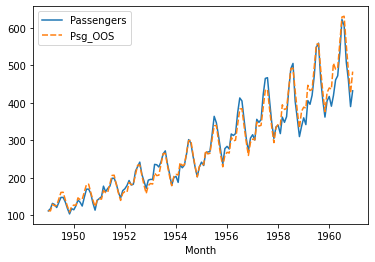

In [9]:
dfplot = df.filter(['Passengers', 'Psg_OOS'])
sns.lineplot(data=dfplot)

Calculate the errors for the in-sample part and the out-of-sample part separately.

In [10]:
from scipy.stats import spearmanr

In [11]:
# dividing the data into the in-sample and out-of-sample periods
y_in = df.Passengers[0:-12]
y_out = df.Passengers.tail(12)
pred_in = df.Psg_OOS[0:-12]
pred_out = df.Psg_OOS.tail(12)

In [12]:
# putting the objects into lists
ys = [y_in, y_out]
preds = [pred_in, pred_out]
descr = ['IN', 'OUT']

In [13]:
# Mean Error
for y, p, d in zip(ys, preds, descr):
    err = np.mean(y-p)
    print(f"{d} error is: {err}")

IN error is: 0.06018080309817418
OUT error is: -35.04822354009142


In [14]:
# Mean Absolute Error
for y, p, d in zip(ys, preds, descr):
    err = np.mean(np.abs(y-p))
    print(f"{d} error is: {err}")

IN error is: 11.848410698267685
OUT error is: 35.04822354009142


In [15]:
# Mean Squared Error
for y, p, d in zip(ys, preds, descr):
    err = np.mean((y-p)**2)
    print(f"{d} error is: {err}")

IN error is: 239.84593819965494
OUT error is: 1612.0334589044094


In [16]:
# Root Mean Squared Error
for y, p, d in zip(ys, preds, descr):
    err = np.sqrt(np.mean((y-p)**2))
    print(f"{d} error is: {err}")

IN error is: 15.486960263384644
OUT error is: 40.1501364742937


In [17]:
# Mean Percentage Error
for y, p, d in zip(ys, preds, descr):
    err = np.mean((y-p)/p)*100
    print(f"{d} error is: {err}")

IN error is: 0.1479236234345939
OUT error is: -7.084615364140211


In [18]:
# Mean Absolute Percentage Error
for y, p, d in zip(ys, preds, descr):
    err = np.mean(np.abs((y-p)/p))*100
    print(f"{d} error is: {err}")

IN error is: 4.473354932000654
OUT error is: 7.084615364140211


In [19]:
# Rank correlation - not going to do this manually, that is too cruel, sorry
for y, p, d in zip(ys, preds, descr):
    err = spearmanr(y, p)
    print(f"{d} Rank correlation is: {err}")

# By the way - doing that on nominal values is controversial, at least for time series: you need to understand well what it does.

IN Rank correlation is: SpearmanrResult(correlation=0.9902685418682643, pvalue=3.229528210128145e-113)
OUT Rank correlation is: SpearmanrResult(correlation=0.9211923058649254, pvalue=2.0949776212051888e-05)


In [20]:
# Rank correlation on nominal changes
for y, p, d in zip(ys, preds, descr):
    err = spearmanr(y.diff(periods=1), p.diff(periods = 1), nan_policy = 'omit')
    print(f"{d} Rank correlation is: {err}")

# We need to omit the NAs, lest we get nan as a result.
# You could do it on percentage changes, too.

IN Rank correlation is: SpearmanrResult(correlation=0.9561147095443893, pvalue=1.228825955409713e-70)
OUT Rank correlation is: SpearmanrResult(correlation=0.8200476856407692, pvalue=0.0019943604695931527)


In [21]:
# Mean directional accuracy
for y, p, d in zip(ys, preds, descr):
    err = np.mean(np.sign(y.diff(periods=1)) == np.sign(p.diff(periods = 1)))
    print(f"{d} Mean directional accuracy is {err}")

IN Mean directional accuracy is 0.8712121212121212
OUT Mean directional accuracy is 0.75


In [22]:
# Mean absolute scaled error
for y, p, d in zip(ys, preds, descr):
    scl = np.abs(y.diff(periods=1)).sum()
    err = np.sum(np.abs(y-p)/scl)
    print(f"{d} Error is: {err}")

IN Error is: 0.49571797533164336
OUT Error is: 0.7920502494935914
